## Vector fields plots

In [2]:
## import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc4
import tarfile
import json
import uuid as uuid
import os
from datetime import datetime, timedelta
from pathlib import Path
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## import ECCO utils
import sys
sys.path.append('/Users/mzahn/github_others/ECCOv4-py')
import ecco_v4_py as ecco

In [3]:
def load_sassie_N1_field(file_dir, fname, nk=1, skip=0):
    num_cols = 680*4 + 1080
    num_rows = 1080
    
    time_level = int(fname.split('.data')[0].split('.')[-1])
    
    tmp_compact = ecco.load_binary_array(file_dir, fname, \
                                    num_rows, num_cols, nk=nk, skip=skip, filetype='>f4')

    return tmp_compact, time_level

In [4]:
def sassie_n1_compact_to_faces_3D(sassie_n1_compact):
    sassie_faces = dict()
    n = 680
    
    # Face 1 
    start_row = 0
    end_row = n
    sassie_faces[1] = sassie_n1_compact[:,start_row:end_row,:]

    # Face 2
    start_row = end_row
    end_row = start_row + n
    sassie_faces[2] = sassie_n1_compact[:,start_row:end_row,:]
    
    # Face 3
    start_row = end_row
    end_row = start_row + 1080
    sassie_faces[3] = sassie_n1_compact[:,start_row:end_row:,:]
    
    #Face 4
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[4] = sassie_n1_compact[:,start_row:end_row].reshape(90, 1080, n)

    #Face 5
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[5] = sassie_n1_compact[:,start_row:end_row].reshape(90, 1080, n)

    return sassie_faces

In [5]:
def plot_ecco_map_2D(faces_ds, vmin_ds=None, vmax_ds=None, cmap='jet', title=" "):
    
    if vmin_ds is None:
        vmin_ds = faces_ds[3].min()
        vmax_ds = faces_ds[3].max()
    
    fig,axs = plt.subplots(3,3, figsize=[7,7])
    ax = axs.ravel()
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax2_cmap = ax[2].imshow(faces_ds[5][:,:], origin='lower', cmap=cmap, vmin=vmin_ds, vmax=vmax_ds)
    
    ax[3].set_axis_off()
    ax[4].imshow(faces_ds[3][:,:], origin='lower', cmap=cmap, vmin=vmin_ds, vmax=vmax_ds)
    ax[5].imshow(faces_ds[4][:,:], origin='lower', cmap=cmap, vmin=vmin_ds, vmax=vmax_ds)
    ax[5].axvline(x=535, color='r')
    
    ax[6].imshow(faces_ds[1][:,:], origin='lower', cmap=cmap, vmin=vmin_ds, vmax=vmax_ds)
    ax[6].axhline(y=680-185, color='r')
    ax[7].imshow(faces_ds[2][:,:], origin='lower', cmap=cmap, vmin=vmin_ds, vmax=vmax_ds)
    ax[8].set_axis_off()
    
    axins = inset_axes(
    ax[2],
    width="10%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.2, 0., 1, 1),
    bbox_transform=ax[2].transAxes,
    borderpad=0)
    cb = fig.colorbar(ax2_cmap, cax=axins)
    
    for ax in ax:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        
    # plt.tight_layout()
    plt.suptitle(title);
    
    plt.show()

In [63]:
def plot_ecco_map_3D(faces_ds, vmin_ds=None, vmax_ds=None, cmap='jet', title=" "):
    
    if vmin_ds is None:
        vmin_ds = faces_ds[3].min()
        vmax_ds = faces_ds[3].max()
    
    fig,axs = plt.subplots(3,3, figsize=[7,7])
    ax = axs.ravel()
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax2_cmap = ax[2].imshow(faces_ds[5][0,:,:], origin='lower', cmap=cmap, vmin=vmin_ds, vmax=vmax_ds)
    
    ax[3].set_axis_off()
    ax[4].imshow(faces_ds[3][0,:,:], origin='lower', cmap=cmap, vmin=vmin_ds, vmax=vmax_ds)
    ax[5].imshow(faces_ds[4][0,:,:], origin='lower', cmap=cmap, vmin=vmin_ds, vmax=vmax_ds)
    ax[5].axvline(x=535, color='k', linestyle='dashed', linewidth=2)
    
    ax[6].imshow(faces_ds[1][0,:,:], origin='lower', cmap=cmap, vmin=vmin_ds, vmax=vmax_ds)
    ax[6].axhline(y=680-185, color='k', linestyle='dashed', linewidth=2)
    ax[7].imshow(faces_ds[2][0,:,:], origin='lower', cmap=cmap, vmin=vmin_ds, vmax=vmax_ds)
    ax[8].set_axis_off()
    
    axins = inset_axes(
    ax[2],
    width="10%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.2, 0., 1, 1),
    bbox_transform=ax[2].transAxes,
    borderpad=0)
    cb = fig.colorbar(ax2_cmap, cax=axins)
    
    for ax in ax:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        
    # plt.tight_layout()
    plt.suptitle(title);
    
    plt.show()

### Load mask files

In [49]:
# hFac_dir = Path('/Users/mzahn/data/grids/grid_sassie/N1_1080/hfac/')
hFac_dir = Path('/Users/mzahn/data/SASSIE/grid/')

num_cols = 680*4 + 1080
num_rows = 1080

# nk=90 because there is only one variable with 90 depth levels
hFacW_compact = ecco.load_binary_array(hFac_dir, 'hFacW.data', num_rows, num_cols, nk=90)
hFacS_compact = ecco.load_binary_array(hFac_dir, 'hFacS.data', num_rows, num_cols, nk=90)

load_binary_array: loading file /Users/mzahn/data/SASSIE/grid/hFacW.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4
load_binary_array: loading file /Users/mzahn/data/SASSIE/grid/hFacS.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4


In [51]:
hFacW_faces = sassie_n1_compact_to_faces_3D(hFacW_compact)
hFacS_faces = sassie_n1_compact_to_faces_3D(hFacS_compact)

In [53]:
np.shape(hFacW_faces[5])

(90, 1080, 680)

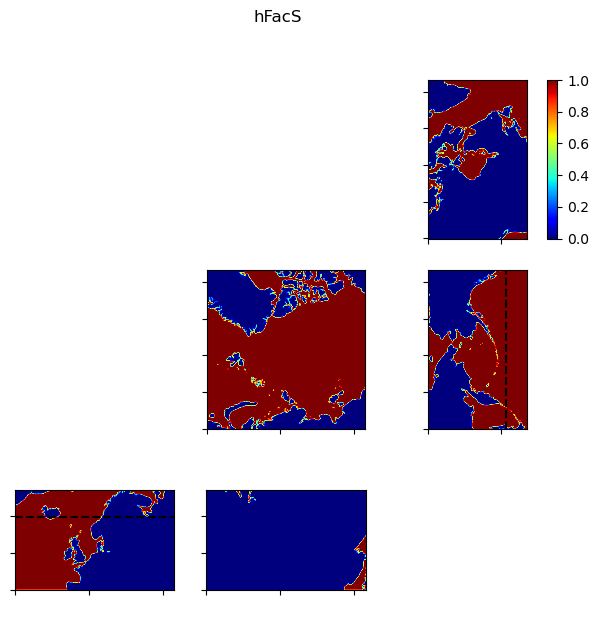

In [55]:
plot_ecco_map_3D(hFacS_faces, vmin_ds=None, vmax_ds=None, cmap='jet', title="hFacS")

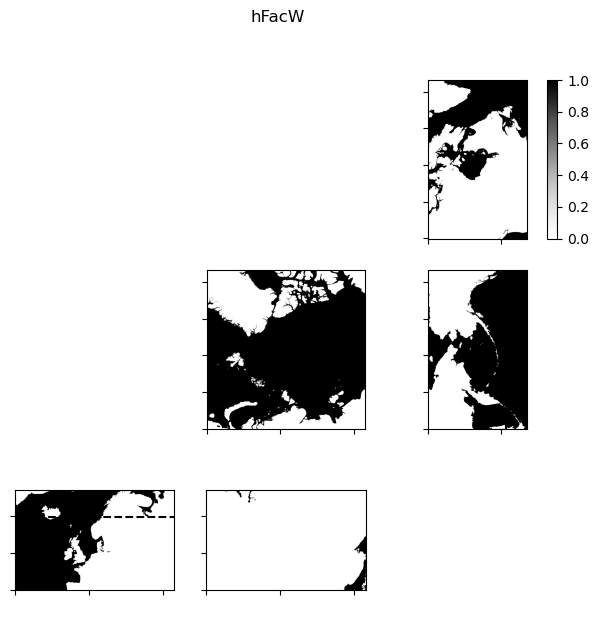

In [57]:
plot_ecco_map_3D(hFacW_faces, vmin_ds=None, vmax_ds=None, cmap='Greys', title="hFacW")

### Run functions

In [15]:
sassie_1080_data_dir = Path('/Users/mzahn/data/SASSIE/SASSIE_examples/')
vel_filename = 'ocean_vel_day_mean/ocean_vel_day_mean.0005796720.data'

uvel_compact, uvel_time_level = load_sassie_N1_field(sassie_1080_data_dir, vel_filename, nk=90, skip=0)
vvel_compact, vvel_level = load_sassie_N1_field(sassie_1080_data_dir, vel_filename, nk=90, skip=90)

load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_vel_day_mean/ocean_vel_day_mean.0005796720.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4
load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_vel_day_mean/ocean_vel_day_mean.0005796720.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4


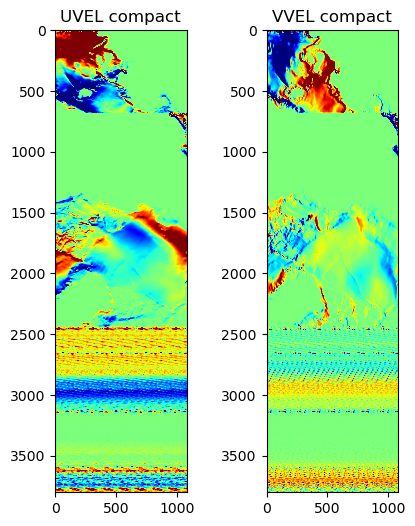

In [23]:
fig,axs = plt.subplots(1,2, figsize=[5,6])
axs[0].imshow(uvel_compact[0,:,:], origin='lower', cmap='jet', vmin=-0.1, vmax=0.1)
axs[1].imshow(vvel_compact[1,:,:], origin='lower', cmap='jet', vmin=-0.1, vmax=0.1)

axs[0].set_title("UVEL compact")
axs[1].set_title("VVEL compact")

for ax in axs:
    ax.invert_yaxis()

In [25]:
uvel_faces = sassie_n1_compact_to_faces_3D(uvel_compact)
vvel_faces = sassie_n1_compact_to_faces_3D(vvel_compact)

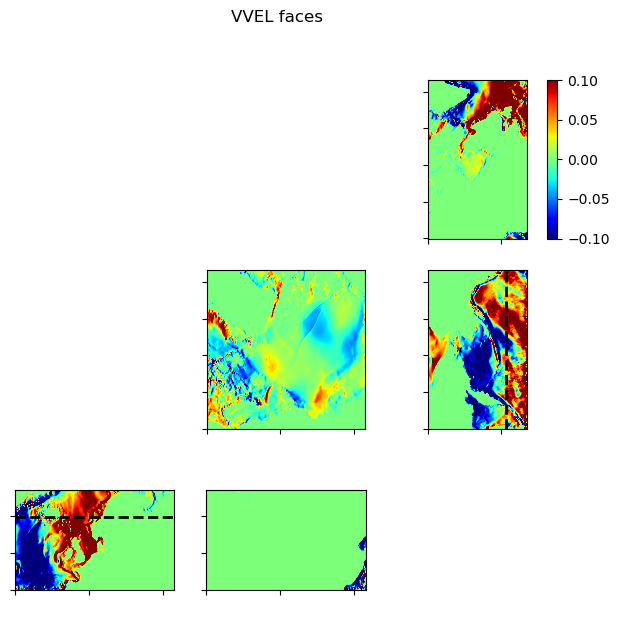

In [65]:
plot_ecco_map_3D(vvel_faces, vmin_ds=-0.1, vmax_ds=0.1, cmap='jet', title="VVEL faces")

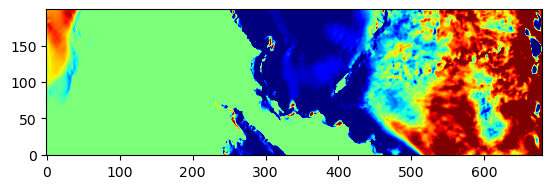

In [137]:
plt.imshow(vvel_faces[4][0,200:400,:],origin='lower',cmap='jet', vmin=-0.1, vmax=0.1)

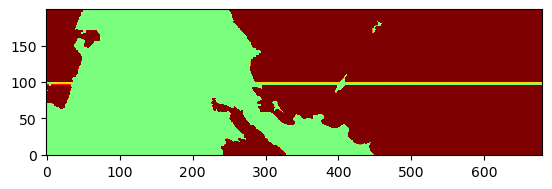

In [135]:
plt.imshow(hFacS_faces[4][0,200:400,:],origin='lower',cmap='jet', vmin=-0.1, vmax=0.1)

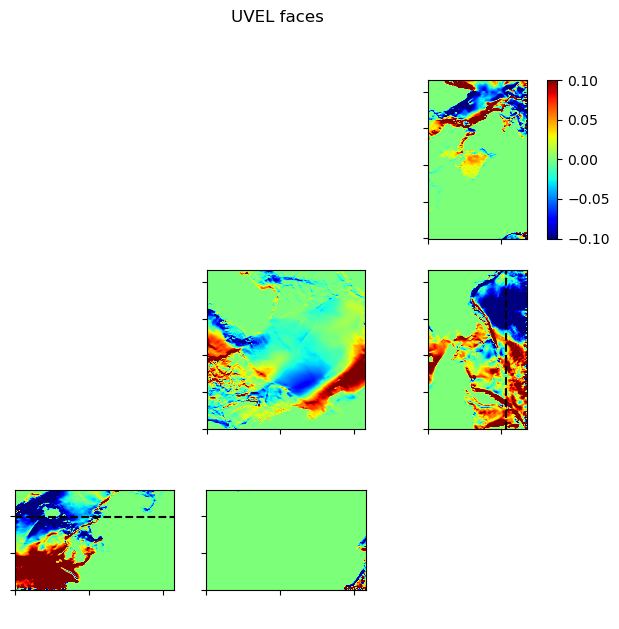

In [47]:
plot_ecco_map_3D(uvel_faces, vmin_ds=-0.1, vmax_ds=0.1, cmap='jet', title="UVEL faces")

### Apply maskW to uvel

In [185]:
hFacW_faces[1][0,:,:]

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype='>f4')

In [181]:
uvel_face4_tmp = uvel_faces[4][0,:,:][hFacW_faces[4][0,:,:] > 0]

In [169]:
faces_masked_u = dict()

faces_masked_u[1] = np.where(hFacW_faces[1][0,:,:] > 0, uvel_faces[1][0,:,:], np.nan)
faces_masked_u[2] = np.where(hFacW_faces[2][0,:,:] > 0, uvel_faces[2][0,:,:], np.nan)
faces_masked_u[3] = np.where(hFacW_faces[3][0,:,:] > 0, uvel_faces[3][0,:,:], np.nan)
faces_masked_u[4] = np.where(hFacW_faces[4][0,:,:] > 0, uvel_faces[4][0,:,:], np.nan)
faces_masked_u[5] = np.where(hFacW_faces[5][0,:,:] > 0, uvel_faces[5][0,:,:], np.nan)

In [171]:
np.any(faces_masked_u == 0)

False

In [173]:
print(np.any(faces_masked_u[1] == 0))
print(np.any(faces_masked_u[2] == 0))
print(np.any(faces_masked_u[3] == 0))
print(np.any(faces_masked_u[4] == 0))
print(np.any(faces_masked_u[5] == 0))

True
True
False
False
True


In [175]:
print(len(np.where(faces_masked_u[1] == 0)[0]))
print(len(np.where(faces_masked_u[2] == 0)[0]))
print(len(np.where(faces_masked_u[3] == 0)[0]))
print(len(np.where(faces_masked_u[4] == 0)[0]))
print(len(np.where(faces_masked_u[5] == 0)[0]))

13901
73
0
0
74


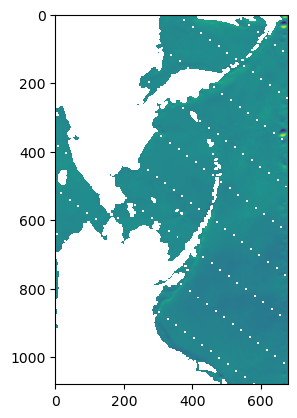

In [177]:
plt.imshow(faces_masked_u[4])

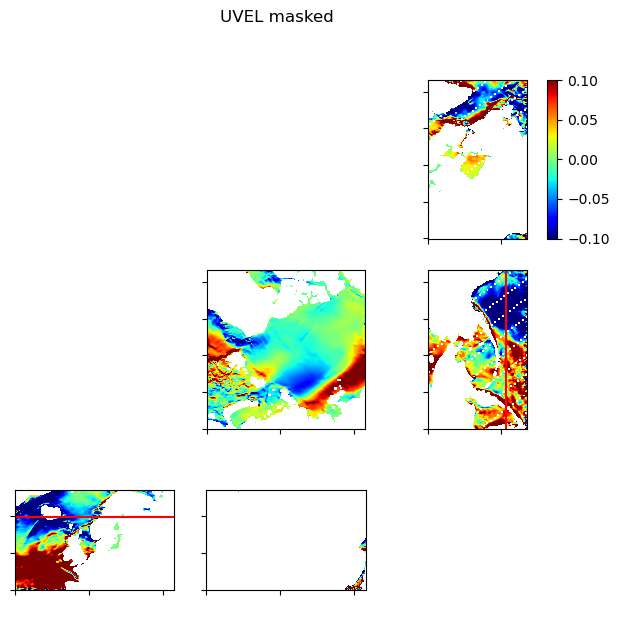

In [159]:
plot_ecco_map_2D(faces_masked_u, vmin_ds=-0.1, vmax_ds=0.1, cmap='jet', title="UVEL masked")

In [222]:
faces_zeros_u = dict()

faces_zeros_u[1] = np.where(faces_masked_u[1] == 0, uvel_faces[1], np.nan)
faces_zeros_u[2] = np.where(faces_masked_u[2] == 0, uvel_faces[2], np.nan)
faces_zeros_u[3] = np.where(faces_masked_u[3] == 0, uvel_faces[3], np.nan)
faces_zeros_u[4] = np.where(faces_masked_u[4] == 0, uvel_faces[4], np.nan)
faces_zeros_u[5] = np.where(faces_masked_u[5] == 0, uvel_faces[5], np.nan)

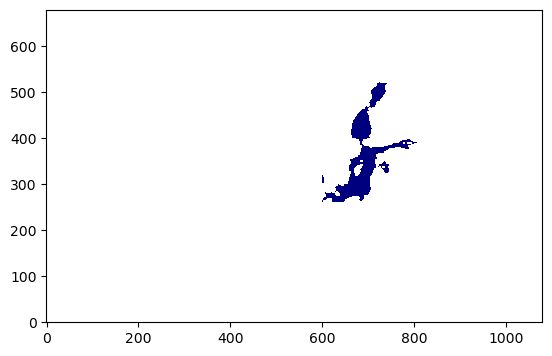

In [224]:
plt.imshow(faces_zeros_u[1][0,:,:], origin='lower', cmap='jet', vmin=0, vmax=1)

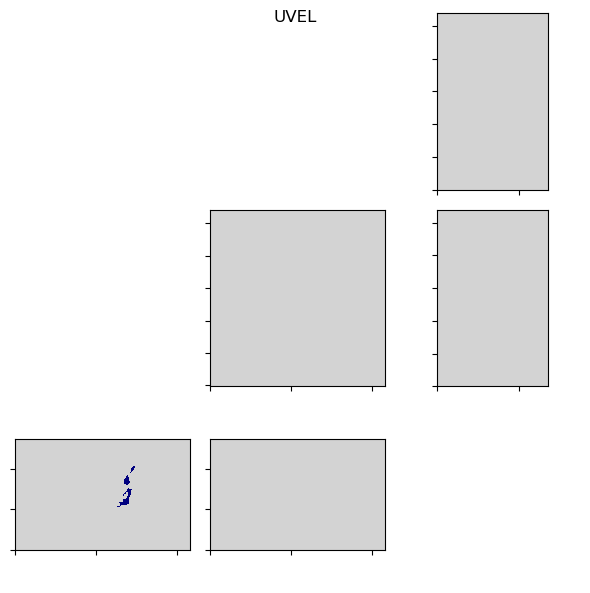

In [226]:
fig,axs = plt.subplots(3,3, figsize=[6,6])
ax = axs.ravel()
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].imshow(faces_zeros_u[5][10,:,:], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[3].set_axis_off()
ax[4].imshow(faces_zeros_u[3][10,:,:], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[5].imshow(faces_zeros_u[4][10,:,:], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[6].imshow(faces_zeros_u[1][10,:,:], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[7].imshow(faces_zeros_u[2][10,:,:], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[8].set_axis_off()

for ax in ax:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_facecolor('lightgray')
    
plt.tight_layout()
plt.suptitle("UVEL");

### Apply maskS to vvel

In [211]:
faces_masked_v = dict()

faces_masked_v[1] = np.where(hFacS_faces[1] > 0, vvel_faces[1], np.nan)
faces_masked_v[2] = np.where(hFacS_faces[2] > 0, vvel_faces[2], np.nan)
faces_masked_v[3] = np.where(hFacS_faces[3] > 0, vvel_faces[3], np.nan)
faces_masked_v[4] = np.where(hFacS_faces[4] > 0, vvel_faces[4], np.nan)
faces_masked_v[5] = np.where(hFacS_faces[5] > 0, vvel_faces[5], np.nan)

In [191]:
np.any(faces_masked_v == 0)

False

In [193]:
print(np.any(faces_masked_v[1] == 0))
print(np.any(faces_masked_v[2] == 0))
print(np.any(faces_masked_v[3] == 0))
print(np.any(faces_masked_v[4] == 0))
print(np.any(faces_masked_v[5] == 0))

True
True
False
True
True


In [195]:
np.where(faces_masked_v[1][0,:,:] == 0, 1, 0).sum()

13977

In [197]:
print(np.where(faces_masked_v[1][0,:,:] == 0, 1, 0).sum())
print(np.where(faces_masked_v[2][0,:,:] == 0, 1, 0).sum())
print(np.where(faces_masked_v[3][0,:,:] == 0, 1, 0).sum())
print(np.where(faces_masked_v[4][0,:,:] == 0, 1, 0).sum())
print(np.where(faces_masked_v[5][0,:,:] == 0, 1, 0).sum())

13977
60
0
0
77


In [199]:
print(len(np.where(faces_masked_v[1] == 0)[0]))
print(len(np.where(faces_masked_v[2] == 0)[0]))
print(len(np.where(faces_masked_v[3] == 0)[0]))
print(len(np.where(faces_masked_v[4] == 0)[0]))
print(len(np.where(faces_masked_v[5] == 0)[0]))

224636
2363
0
2524
2493


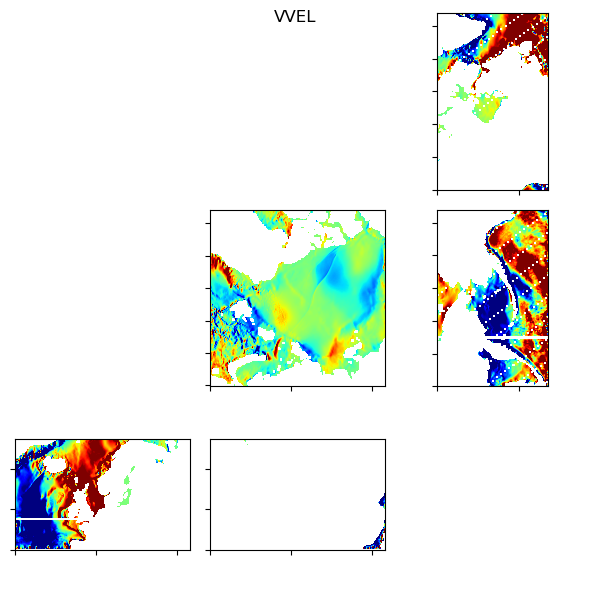

In [201]:
fig,axs = plt.subplots(3,3, figsize=[6,6])
ax = axs.ravel()
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].imshow(faces_masked_v[5][0,:,:], origin='lower', cmap='jet', vmin=-0.1, vmax=0.1)
ax[3].set_axis_off()
ax[4].imshow(faces_masked_v[3][0,:,:], origin='lower', cmap='jet', vmin=-0.1, vmax=0.1)
ax[5].imshow(faces_masked_v[4][0,:,:], origin='lower', cmap='jet', vmin=-0.1, vmax=0.1)
ax[6].imshow(faces_masked_v[1][0,:,:], origin='lower', cmap='jet', vmin=-0.1, vmax=0.1)
ax[7].imshow(faces_masked_v[2][0,:,:], origin='lower', cmap='jet', vmin=-0.1, vmax=0.1)
ax[8].set_axis_off()

for ax in ax:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
plt.tight_layout()
plt.suptitle("VVEL");

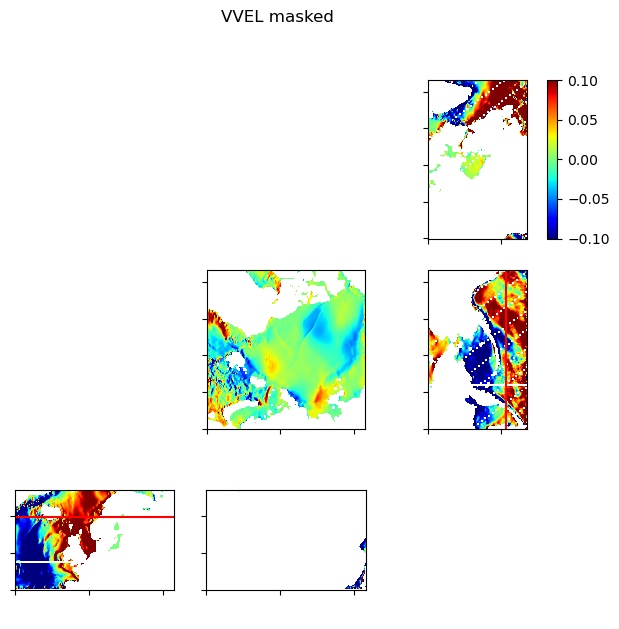

In [213]:
plot_ecco_map_3D(faces_masked_v, vmin_ds=-0.1, vmax_ds=0.1, cmap='jet', title="VVEL masked")

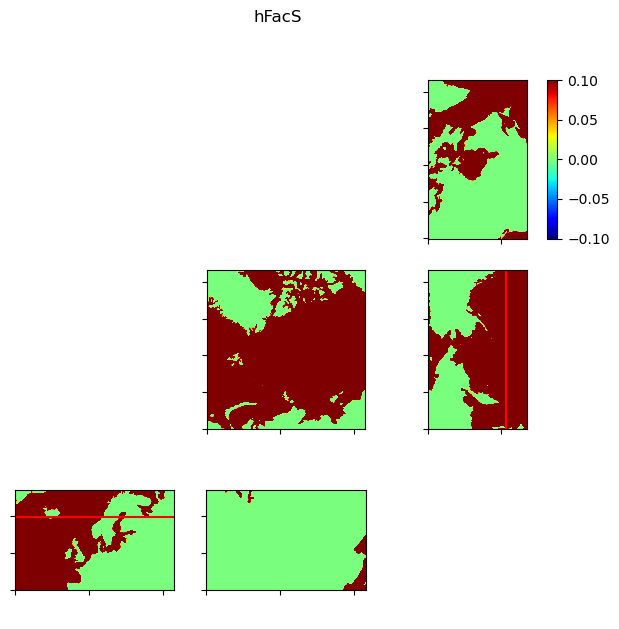

In [215]:
plot_ecco_map_3D(hFacS_faces, vmin_ds=-0.1, vmax_ds=0.1, cmap='jet', title="hFacS")

In [205]:
faces_zeros_v = dict()

faces_zeros_v[1] = np.where(faces_masked_v[1] == 0, vvel_faces[1], np.nan)
faces_zeros_v[2] = np.where(faces_masked_v[2] == 0, vvel_faces[2], np.nan)
faces_zeros_v[3] = np.where(faces_masked_v[3] == 0, vvel_faces[3], np.nan)
faces_zeros_v[4] = np.where(faces_masked_v[4] == 0, vvel_faces[4], np.nan)
faces_zeros_v[5] = np.where(faces_masked_v[5] == 0, vvel_faces[5], np.nan)

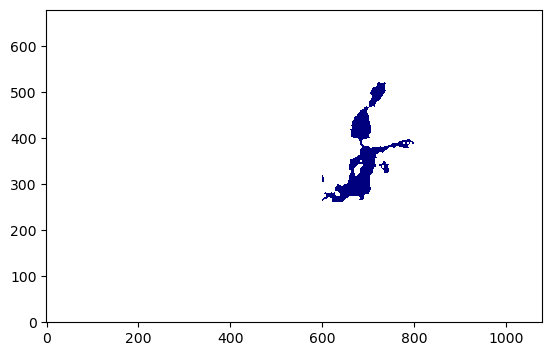

In [207]:
plt.imshow(faces_zeros_v[1][0,:,:], origin='lower', cmap='jet', vmin=0, vmax=1)

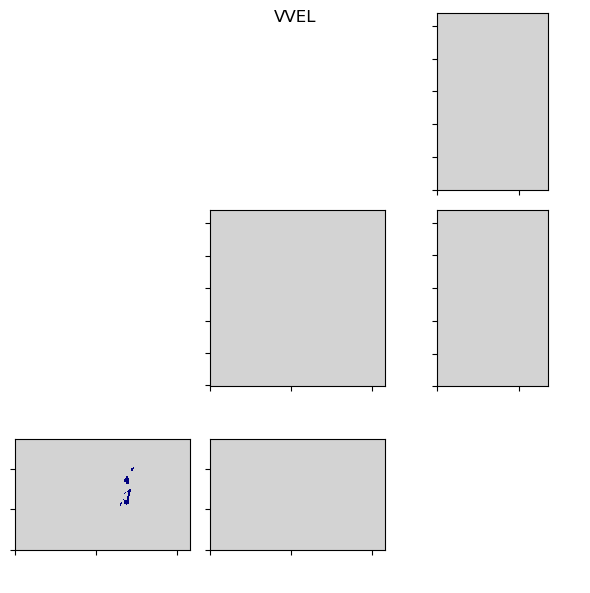

In [357]:
fig,axs = plt.subplots(3,3, figsize=[6,6])
ax = axs.ravel()
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].imshow(faces_zeros_v[5][10,:,:], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[3].set_axis_off()
ax[4].imshow(faces_zeros_v[3][10,:,:], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[5].imshow(faces_zeros_v[4][10,:,:], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[6].imshow(faces_zeros_v[1][10,:,:], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[7].imshow(faces_zeros_v[2][10,:,:], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[8].set_axis_off()

for ax in ax:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_facecolor('lightgray')
    
plt.tight_layout()
plt.suptitle("VVEL");

### Walk through processing to HH

In [197]:
def combine_sassie_N1_faces_to_HHv2_3D_u_point(face_arr_u, face_arr_v):
    """
    3D function for vector fields, u point
    """
    ## dimensions of the final Arctic HH field. 535+185+1080=1800 ; 90 vertical levels
    new_arr = np.zeros((90, 1080, 1800))
    
    ## add Arctic face (3)
    new_arr[:,:,185:185+1080] = face_arr_u[3] # take entire Artic face
    
    ## add face 1 that will be flipped (must use v array)
    new_arr[:,:,0:185] = np.transpose(face_arr_v[1][:,-185:,::-1],axes=(0,2,1))
        
    ## add part of face 4 (Alaska)
    new_arr[:,:,185+1080:] = face_arr_u[4][:,:,:535]

    ## rotate by 90 deg twice to have Alaska on bottom left
    ## since it is vector field, have to multiply whole array by -1
    new_arr = np.rot90(new_arr,2,axes=(1,2))
    new_arr = new_arr *-1
        
    return new_arr

In [199]:
def combine_sassie_N1_faces_to_HHv2_3D_v_point(face_arr_v, face_arr_u):
    """
    3D function for vector fields, v point
    """
    ## dimensions of the final Arctic HH field. 535+185+1080=1800
    new_arr = np.zeros((90, 1080, 1800))
    
    ## add Arctic face (3)
    new_arr[:,:,185:185+1080] = face_arr_v[3]
    
    ## add part of face 1 (Europe) that will be flipped (must use u array and multiply by -1)
    
    ## after rotating face 1, the u points on face 1 will not match the v points of face 3 (offset by 1 upwards)
    ## therefore, must remove the first column of face 1 and add the first column from face 2 to the end of face 1
    ## remove the first i column from the u field so the shape is (680, 1079) = (j,i)
    face1_tmp = face_arr_u[1][:,:,1:]
    ## then add the first row from face 2 to the end of face 1
    face1_mod = np.concatenate((face1_tmp, face_arr_u[2][:,:,:1]), axis=2)
    
    ## add modified face 1 by rotating and multiplying by -1
    new_arr[:,:,0:185] = np.transpose(face1_mod[:,-185:,::-1],axes=(0,2,1))*-1
    
    ## add part of face 4 (Alaska)
    new_arr[:,:,185+1080:] = face_arr_v[4][:,:,:535]

    ## rotate by 90 deg twice to have Alaska on bottom left
    new_arr = np.rot90(new_arr,2,axes=(1,2))
    new_arr = new_arr *-1
        
    return new_arr

In [ ]:
combine_sassie_N1_faces_to_HHv2_3D_v_point(face_arr_v, face_arr_u)

In [201]:
tmp_HH = combine_sassie_N1_faces_to_HHv2_3D_u_point(faces_masked_u, faces_masked_v)

In [ ]:
## dimensions of the final Arctic HH field. 535+185+1080=1800 ; 90 vertical levels
new_arr = np.zeros((90, 1080, 1800))

## add Arctic face (3)
new_arr[:,:,185:185+1080] = faces_masked_u[3] # take entire Artic face

## add face 1 that will be flipped (must use v array)
new_arr[:,:,0:185] = np.transpose(faces_masked_v[1][:,-185:,::-1],axes=(0,2,1))
    
## add part of face 4 (Alaska)
new_arr[:,:,185+1080:] = faces_masked_u[4][:,:,:535]

## rotate by 90 deg twice to have Alaska on bottom left
## since it is vector field, have to multiply whole array by -1
new_arr = np.rot90(new_arr,2,axes=(1,2))
new_arr = new_arr *-1

In [241]:
print(np.any(faces_masked_u==0))
print(np.any(faces_masked_v==0))
print(np.any(tmp_HH==0))

False
False
True


In [221]:
print(np.any(faces_masked_u[3] == 0))
print(np.any(np.transpose(faces_masked_v[1][:,-185:,::-1],axes=(0,2,1)) == 0))
print(np.any(faces_masked_u[4][:,:,:535] == 0))

False
True
False


In [229]:
np.shape(faces_masked_v[1])

(90, 680, 1080)

In [237]:
np.any(faces_masked_v[1] == 0)

True

In [235]:
np.any(faces_masked_v[1][:,:,:] == 0)

True